# Multimodal Retrieval

Chroma supports multimodal collections, i.e. collections which contain, and can be queried by, multiple modalities of data.

This notebook shows an example of how to create and query a collection with both text and images, using Chroma's built-in features. 

## Dataset

We us a small subset of the [coco object detection dataset](https://huggingface.co/datasets/detection-datasets/coco), hosted on HuggingFace. 

We download a small fraction of all the images in the dataset locally, and use it to create a multimodal collection.

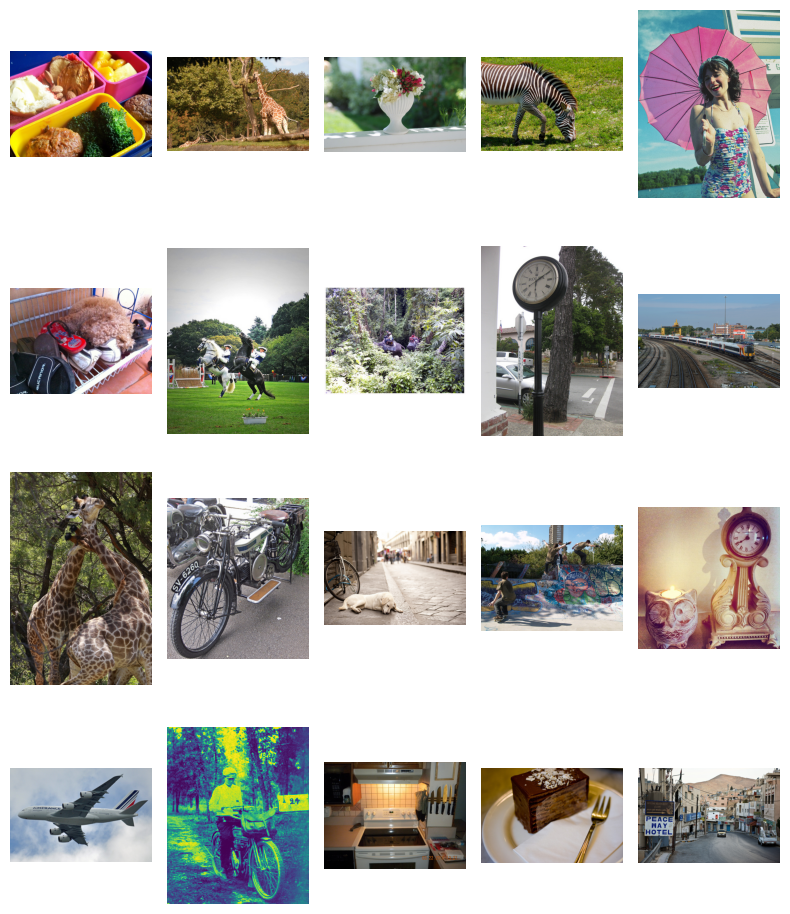

In [16]:
import os
from datasets import load_dataset
from matplotlib import pyplot as plt

dataset = load_dataset(path="detection-datasets/coco", name="coco", split="train", streaming=True)

IMAGE_FOLDER = "images"
N_IMAGES = 20

# For plotting
plot_cols = 5
plot_rows = N_IMAGES // plot_cols
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(plot_rows*2, plot_cols*2))
axes = axes.flatten()

# Write the images to a folder
dataset_iter = iter(dataset)
os.makedirs(IMAGE_FOLDER, exist_ok=True)
for i in range(N_IMAGES):
    image = next(dataset_iter)['image']
    axes[i].imshow(image)
    axes[i].axis("off")

    image.save(f"images/{i}.jpg")

plt.tight_layout()
plt.show()

## Ingesting multimodal data

Chroma supports multimodal collections by referencing external URIs for data types other than text.
All you have to do is specify a data loader when creating the collection, and then provide the URI for each entry. 

### Creating a multi-modal collection

First we create the default Chroma client. 

In [17]:
import chromadb
client = chromadb.Client()

Next we specify an embedding function and a data loader.

The built-in `OpenCLIPEmbeddingFunction` works with both text and image data. The `ImageLoader` is a simple data loader that loads images from a local directory.

In [18]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from chromadb.utils.data_loaders import ImageLoader

embedding_function = OpenCLIPEmbeddingFunction()
image_loader = ImageLoader()

We create a collection with the embedding function and data loader.

In [19]:
collection = client.create_collection(
    name='multimodal_collection', 
    embedding_function=embedding_function, 
    data_loader=image_loader)

### Adding multi-modal data

We add image data to the collection using the image URIs. The data loader and embedding functions we specified earlier will ingest data from the provided URIs automatically. 

In [42]:
# Get the uris to the images
image_uris = sorted([os.path.join(IMAGE_FOLDER, image_name) for image_name in os.listdir(IMAGE_FOLDER)])
ids = [str(i) for i in range(len(image_uris))]

collection.add(ids=ids, uris=image_uris)

## Querying a multi-modal collection

We can query the collection using text as normal, since the `OpenCLIPEmbeddingFunction` works with both text and images.

Querying with text:

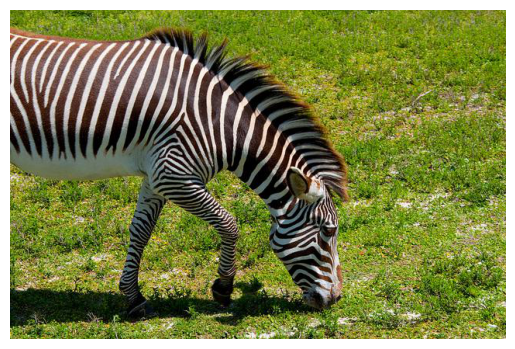

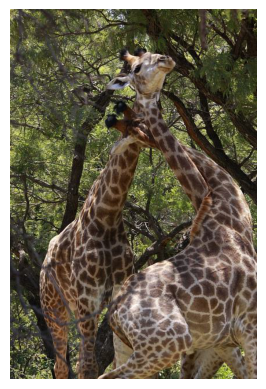

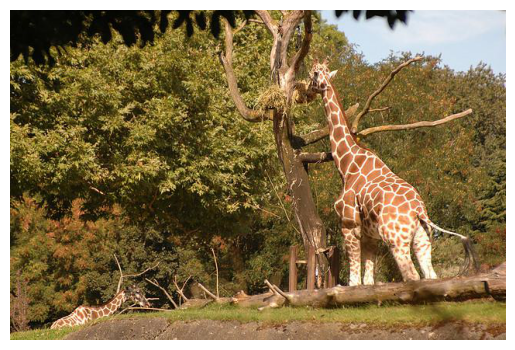

In [43]:
# Querying for "Animals"

retrieved = collection.query(query_texts=["animals"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

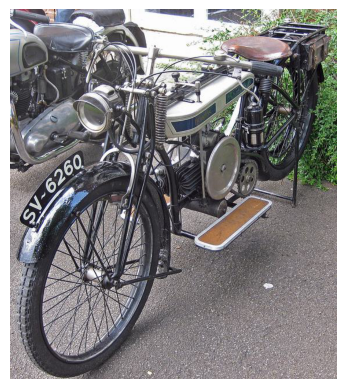

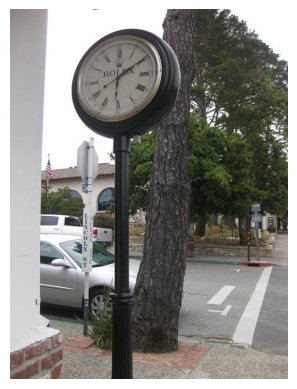

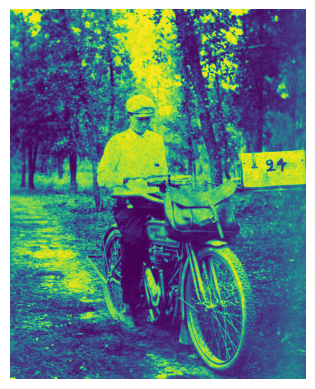

In [44]:
# Querying for "Vehicles"

retrieved = collection.query(query_texts=["vehicles"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

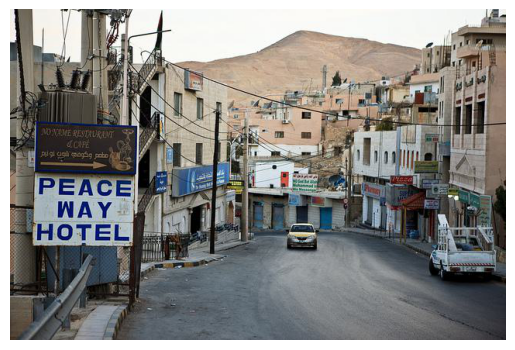

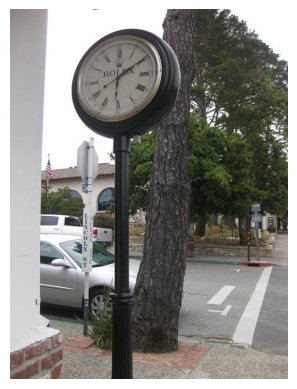

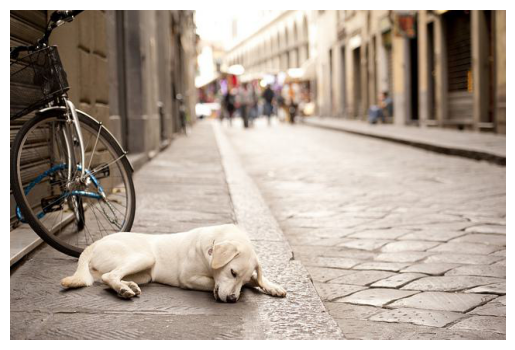

In [45]:
# Querying for "Street Scenes"

retrieved = collection.query(query_texts=["street scene"], include=['data'], n_results=3)
for img in retrieved['data'][0]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

We can also query by images directly, by using the `query_images` field in the `collection.query` method.

Query Image


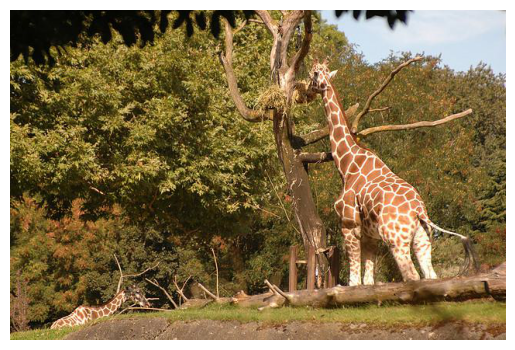

Results


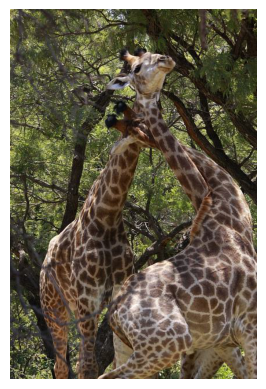

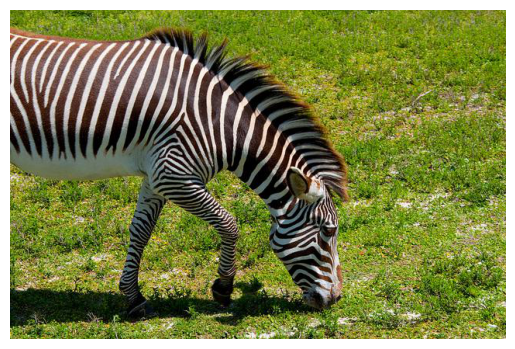

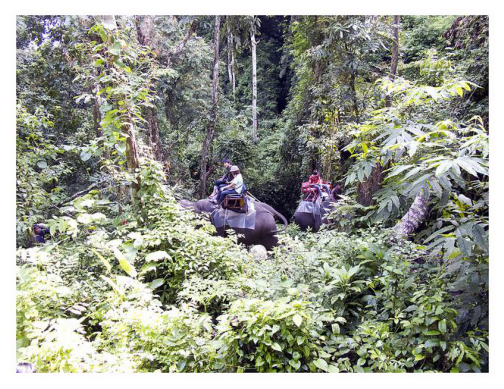

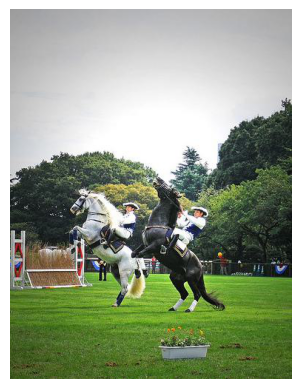

In [56]:
from PIL import Image
import numpy as np

query_image = np.array(Image.open(f"{IMAGE_FOLDER}/1.jpg"))
print("Query Image")
plt.imshow(query_image)
plt.axis('off')
plt.show()

print("Results")
retrieved = collection.query(query_images=[query_image], include=['data'], n_results=5)
for img in retrieved['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

And we can query by URI too, by using the `query_uris` field in the `collection.query` method. The URIs we query by don't necessarily have to be in the collection! 

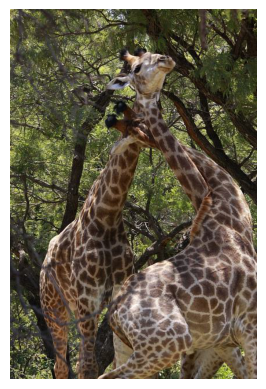

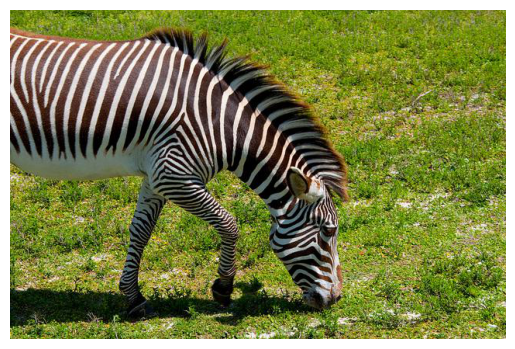

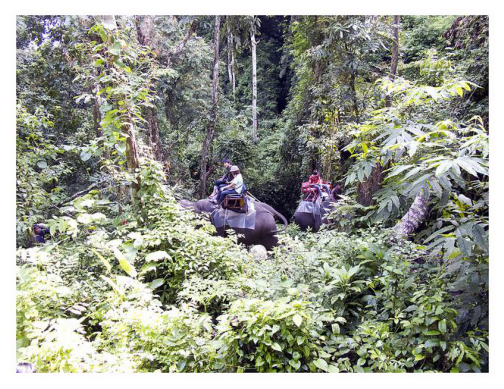

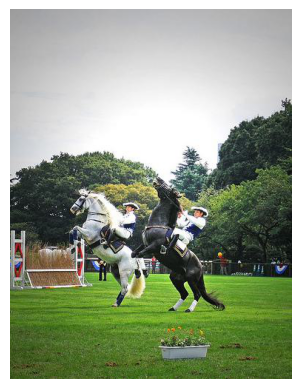

In [58]:
query_uri = image_uris[1]

query_result = collection.query(query_uris=query_uri, include=['data'], n_results=5)
for img in query_result['data'][0][1:]:
    plt.imshow(img)
    plt.axis("off")
    plt.show()

## Next Steps

Multi-modal retrieval is powerful extension to basic text retrieval. As AI systems begin to understand more types of data, like images, audio, and video, we can store and query them alongside documents and text to build even more powerful applications. 